In [1]:
%matplotlib inline
#%matplotlib qt
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt
import root_numpy
import pandas as pd
import numpy
from scipy.stats import gaussian_kde
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


BRICK_X = 124000
# Changed due to ignorance of 57th layer. Originally : #BRICK_Y = 99000
BRICK_Y = 76710
BRICK_Z = 75000
SAFE_M = 10000
dZ = 205

In [2]:
def load_bg(step=1000):
    # ignore 57th layer since it looks different
    etalon_plates = []
    for p in range(48, 57):
        backtracks = root_numpy.root2array("data-2016/129294.{p}.1.1000.cp.root".format(p=p), 
                                       treename="couples", 
                                       branches=["s.eX", "s.eY", "s.eZ",
                                                "s.eTX", "s.eTY",
                                                "s.eChi2"], step=step)
        etalon_plates.append(backtracks)
        
    df = None
    for p in range(58):
        plate = numpy.copy(etalon_plates[p % len(etalon_plates)])
        plate['s.eZ'] = p * 1293
        # plt.hist(backtracks['s.eY'], bins=100, histtype='step', label="%d"%p)
        if df is None:
            df = pd.DataFrame(plate)
            # print ">", df.shape
        else:
            df = pd.concat([df, pd.DataFrame(plate)], ignore_index=True)
    # plt.legend()
    print ("bg: {n} tracks".format(n=df.shape[0]))
    return df

In [3]:
def load_mc(filename="data-2016/mcdata_taue2.root", step=1):
    mc = root_numpy.root2array(
                        filename,
                        treename="Data",
                        branches=["Event_id", "ele_P",
                                   "BT_X", "BT_Y", "BT_Z",
                                   "BT_SX", "BT_SY",
                                   "ele_x", "ele_y", "ele_z", 
                                   "ele_sx", "ele_sy", 
                                   "chisquare"],
                        step=step)
    pmc = pd.DataFrame(mc)
    pmc['numtracks'] = pmc.BT_X.apply(lambda x: len(x))
    # cuts
    shapechange = [pmc.shape[0]]
    pmc = pmc[pmc.ele_P > 0.1]
    shapechange.append(pmc.shape[0])
    pmc = pmc[pmc.ele_x.abs() < BRICK_X / 2 - SAFE_M]
    shapechange.append(pmc.shape[0])
    pmc = pmc[pmc.ele_y.abs() < BRICK_Y / 2 - SAFE_M]
    shapechange.append(pmc.shape[0])
    pmc = pmc[pmc.ele_z < 0]
    shapechange.append(pmc.shape[0])
    pmc = pmc[pmc.numtracks > 3]
    shapechange.append(pmc.shape[0])
    print ("numtracks reduction by cuts: ", shapechange)
    # calc centers
    # to brick reference frame and center
    pmc['m_BT_X'] = pmc.BT_X.apply(lambda x: x.mean())
    pmc['m_BT_Y'] = pmc.BT_Y.apply(lambda x: x.mean())
    pmc['m_BT_Z'] = pmc.BT_Z.apply(lambda x: x.mean())
    pmc.BT_X += BRICK_X / 2
    pmc.BT_Y += BRICK_Y / 2
    pmc.BT_Z += BRICK_Z / 2
    pmc.ele_x += BRICK_X / 2
    pmc.ele_y += BRICK_Y / 2
    pmc.ele_z += BRICK_Z / 2
    print ("len(pmc): {len}".format(len=len(pmc)))
    return pmc

In [4]:
pbg = load_bg(step=1)

TClass::TClass:0: RuntimeWarning: no dictionary for class EdbPoint2D is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbPoint is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbTrack2D is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbAngle2D is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbSegCouple is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbSegP is available
TClass::TClass:0: RuntimeWarning: no dictionary for class EdbID is available


bg: 27322110 tracks


In [5]:
pmc = load_mc(step=1)

numtracks reduction by cuts:  [18724, 18679, 15471, 8734, 4478, 4288]
len(pmc): 4288


In [6]:
#plt.hist(pbg['s.eTX'], bins=100, normed=True);

In [7]:
def plot_bg_and_mc(pbg, pmc, id=1, step=1):
    df = pbg.sample(22732)
    # mind the order!
    d0 = pd.DataFrame([
                df['s.eZ'][::step],
                df['s.eX'][::step],
                df['s.eY'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['s.eTX'][::step]*dZ,
            df['s.eTY'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.5, lw=2)
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-84, elev=10)
    for id in [id]:
        df = pmc.iloc[id]
        # mind the order!
        d0 = pd.DataFrame([
                    df['BT_Z'],
                    df['BT_X'],
                    df['BT_Y']],
                    index=['z', 'x', 'y']).T
        numtracks = d0.shape[0]
        dd = pd.DataFrame([
                df['BT_SX']*dZ,
                df['BT_SY']*dZ],
                index=['x', 'y']).T
        dd.insert(loc=0, column='z', value=dZ)
        d1 = d0 + dd
        #print (d0, d1)
        C = plt.cm.Reds(0.5)
        lc_mc = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.9, lw=2)

        ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)

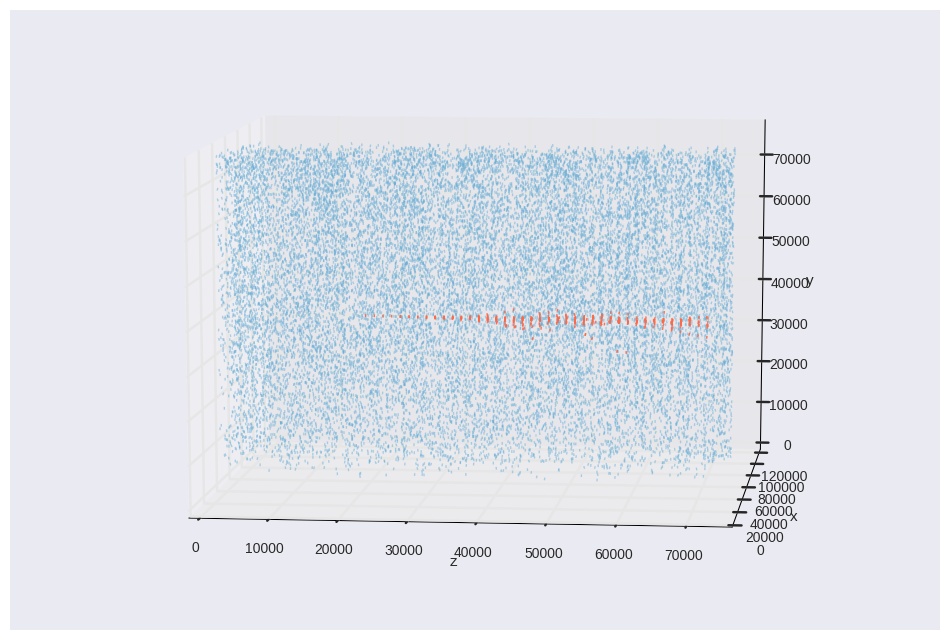

In [8]:
plot_bg_and_mc(pbg, pmc, id=10)

In [9]:
def combine_mc_bg(pmc, pbg, id=0, even = True):
    dZ = 204
    pbg = pbg.sample(27322)
    dmix = pd.DataFrame([
                pbg['s.eX'],
                pbg['s.eY'],
                pbg['s.eZ'],
                pbg['s.eTX'],
                pbg['s.eTY'],
                pbg['s.eX'] + pbg['s.eTX']*dZ,
                pbg['s.eY'] + pbg['s.eTY']*dZ,
                pbg['s.eZ'] + dZ,
                pbg['s.eChi2']],
                index=['sx', 'sy', 'sz', 'TX', 'TY', 
                       'ex', 'ey', 'ez', 'chi2']).T
    #d0['signal'] = 0
    dmix['signal'] = 0
    df = pmc.iloc[id]   
    dmc = pd.DataFrame([        
                df['BT_X'],
                df['BT_Y'],
                df['BT_Z'],
                df['BT_SX'],
                df['BT_SY'],
                df['BT_X'] + df['BT_SX']*dZ,
                df['BT_Y'] + df['BT_SY']*dZ,
                df['BT_Z'] + dZ,
                df['chisquare'][:len(df['BT_X'])]],
                index=['sx', 'sy', 'sz', 'TX', 'TY', 
              'ex', 'ey', 'ez', 'chi2']).T
    dmc['signal'] = 1
    
    dd = pd.concat([dmix, dmc])
    dd['ele_x'] = df['ele_x']
    dd['ele_y'] = df['ele_y']
    dd['ele_z'] = df['ele_z']
    dd['ele_sx'] = df['ele_sx']
    dd['ele_sy'] = df['ele_sy']
    return dd

# Хафа преобразование

Так как углы наклона base-track известны, то понятно, что можно просто перевести весь массив base-track'ов в параметрическое пространство(5 параметров: направляющий вектор + x, y, вид параметризации взят из https://lionel.kr.hs-niederrhein.de/~dalitz/data/publications/hough3d-visapp16.pdf ).
А дальше можно просто либо гистограмму, либо с помощью gaussian_kde оценить плотность распределения.

Прямого применения для нахождения вершины и направления она не нашла, но, зато, значение плотности распределения используется как ещё одна переменная.

In [10]:
def cartesian_to_spherical(x,y,z):
    r_xy = x**2 + y**2
    r = numpy.sqrt(r_xy + z**2)
    theta = numpy.arctan2(z, numpy.sqrt(r_xy))
    phi = numpy.arctan2(y, x)
    return numpy.array([numpy.cos(phi)*numpy.cos(theta), numpy.sin(phi)*numpy.cos(theta), numpy.sin(theta)])

def Simple_Hough3D(sx, sy, sz, ex, ey):
    B = cartesian_to_spherical(ex - sx, ey - sy, 205)
    X = (1 - B[0]**2/(1 + B[2])) * sx - B[0] * B[1] / (1 + B[2]) * sy - B[0] * sz
    Y = - B[0] * B[1] / (1 + B[2]) * sx + (1 - B[1]**2/(1 + B[2])) * sy - B[1] * sz
    return B, X.reshape((1,-1)), Y.reshape((1,-1))

In [12]:
num_idx = 10
train = pd.DataFrame()
for id in numpy.arange(0, num_idx):
    train_tmp = combine_mc_bg(pmc, pbg, id=id)

    train_tmp.TX = train_tmp.TX - train_tmp.ele_sx
    train_tmp.TY = train_tmp.TY - train_tmp.ele_sy

    train_tmp = train_tmp.loc[train_tmp.chi2 < 3, :]

    B, X, Y = Simple_Hough3D(train_tmp.sx.values, train_tmp.sy.values, train_tmp.sz.values, train_tmp.ex.values, train_tmp.ey.values)

    kernel_train = gaussian_kde(numpy.concatenate([B, X, Y]))
    density_train = kernel_train(numpy.concatenate([B, X, Y]))

    train_tmp['pdf_density'] = density_train
    train_tmp['group'] = id
    train = train.append(train_tmp)

In [13]:
train.head()

,sx,sy,sz,TX,TY,ex,ey,ez,chi2,signal,ele_x,ele_y,ele_z,ele_sx,ele_sy,pdf_density,group
8977574,56183.460938,46109.476562,24567.0,0.097343,0.022397,56151.677008,46135.135938,24771.0,1.396739,0,28176.910156,49920.78125,29823.035156,-0.253147,0.103384,1.764944e-08,0
20025231,63521.765625,16879.492188,54306.0,0.132630,0.076183,63497.180134,16916.123772,54510.0,2.302916,0,28176.910156,49920.78125,29823.035156,-0.253147,0.103384,7.512883e-09,0
11493153,69372.882812,47532.792969,31032.0,0.571302,-0.133704,69437.786382,47526.607701,31236.0,1.903351,0,28176.910156,49920.78125,29823.035156,-0.253147,0.103384,3.592724e-09,0
3964963,42822.546875,24629.464844,10344.0,0.238787,-0.065094,42819.617411,24637.276116,10548.0,2.126297,0,28176.910156,49920.78125,29823.035156,-0.253147,0.103384,2.293284e-08,0
13260979,28753.250000,32950.507812,36204.0,0.828556,0.075448,28870.633484,32986.989509,36408.0,1.813117,0,28176.910156,49920.78125,29823.035156,-0.253147,0.103384,8.491551e-10,0


In [14]:
train['X_proj'] = train['sx'] - train['TX']*(train['sz'] - train['ele_z'])
train['Y_proj'] = train['sy'] - train['TY']*(train['sz'] - train['ele_z'])

train['IP/dZ'] = numpy.sqrt((train['ele_x'] - train['X_proj'])**2 + (train['ele_y'] - train['Y_proj'])**2)/(train['sz'] - train['ele_z'])

angle_cos = (
    cartesian_to_spherical(
        train.ele_sx.values, 
        train.ele_sy.values, 
        1) * 
    cartesian_to_spherical(
        (train.sx - train.ele_x).values, 
        (train.sy - train.ele_y).values, 
        (train.sz - train.ele_z).values)
).sum(axis = 0)

train['alpha'] = numpy.arccos(angle_cos)

In [15]:
features = list(set(train.columns) - {'signal', 'sx', 'sx', 'sy', 'sz', 'ex', 'ey', 'ez', 'X_proj', 'Y_proj',
                                     'ele_x', 'ele_y', 'ele_z', 'ele_sx', 'ele_sy', 'group'})

In [16]:
features

['TY', 'alpha', 'chi2', 'IP/dZ', 'pdf_density', 'TX']

In [17]:
params = {'max_depth' : [3],
          'n_estimators' : [100],
           'min_child_weight':[1],
           'subsample':[0.8], 
           'colsample_bytree':[0.8]}

clf = GridSearchCV(XGBClassifier(silent=False, learning_rate=0.1), params, scoring='roc_auc', cv=2, refit=True)
clf.fit(train[features], train.signal, groups=train.group);

In [18]:
clf.grid_scores_

/home/acapello/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.99965, std: 0.00013, params: {'n_estimators': 100, 'colsample_bytree': 0.8, 'subsample': 0.8, 'max_depth': 3, 'min_child_weight': 1}]

In [21]:
from sklearn.metrics import roc_curve, auc

for id in numpy.arange(11,21):
    test = combine_mc_bg(pmc, pbg, id=id)
    test = test.loc[test.chi2 < 3, :]
    B, X, Y = Simple_Hough3D(test.sx.values, test.sy.values, test.sz.values, test.ex.values, test.ey.values)

    kernel_test = gaussian_kde(numpy.concatenate([B, X, Y]))
    density_test = kernel_test(numpy.concatenate([B, X, Y]))

    test['pdf_density'] = density_test

    test.TX = test.TX - test.ele_sx
    test.TX = test.TX - test.ele_sx

    test['X_proj'] = test['sx'] - test['TX']*(test['sz'] - test['ele_z'])
    test['Y_proj'] = test['sy'] - test['TY']*(test['sz'] - test['ele_z'])

    test['IP/dZ'] = numpy.sqrt((test['ele_x'] - test['X_proj'])**2 + (test['ele_y'] - test['Y_proj'])**2)/(test['sz'] - test['ele_z'])

    angle_cos = (
        cartesian_to_spherical(
            test.ele_sx.values, 
            test.ele_sy.values, 
            1) * 
        cartesian_to_spherical(
            (test.sx - test.ele_x).values, 
            (test.sy - test.ele_y).values, 
            (test.sz - test.ele_z).values)
    ).sum(axis = 0)

    test['alpha'] = numpy.arccos(angle_cos)
    y_score = clf.predict_proba(test[features])
    fpr, tpr, _ = roc_curve(test.signal.values, y_score[:, 1], drop_intermediate=True)
    roc_auc = auc(fpr, tpr)
    print ('For #', id)
    print ('ROC AUC =', roc_auc)
    print ("False positive rate =",fpr[tpr > .5][0], "while True positive = 0.5")
    print ("True positive rate = ", tpr[fpr == 0.][-1], ", while False postive rate = 0.0")
    print ()

For # 11
ROC AUC = 0.999386779691
False positive rate = 0.0 while True positive = 0.5
True positive rate =  0.515418502203 , while False postive rate = 0.0

For # 12
ROC AUC = 0.997760524247
False positive rate = 0.000146402166752 while True positive = 0.5
True positive rate =  0.208695652174 , while False postive rate = 0.0

For # 13
ROC AUC = 0.998327713954
False positive rate = 7.3201083376e-05 while True positive = 0.5
True positive rate =  0.317275747508 , while False postive rate = 0.0

For # 14
ROC AUC = 0.999473047061
False positive rate = 0.0 while True positive = 0.5
True positive rate =  0.565874730022 , while False postive rate = 0.0

For # 15
ROC AUC = 0.999996638726
False positive rate = 0.0 while True positive = 0.5
True positive rate =  0.989795918367 , while False postive rate = 0.0

For # 16
ROC AUC = 1.0
False positive rate = 0.0 while True positive = 0.5
True positive rate =  1.0 , while False postive rate = 0.0

For # 17
ROC AUC = 0.999818063327
False positive rate

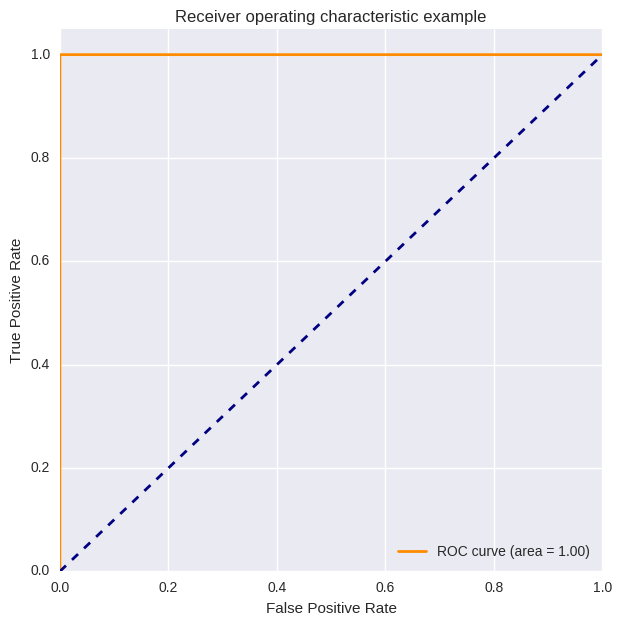

In [22]:
y_score = clf.predict_proba(test[features])

fpr, tpr, _ = roc_curve(test.signal.values, y_score[:, 1], drop_intermediate=True)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()